In [1]:
import numpy as np
from pc_kriging import PC_Kriging
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize
import pandas as pd
from numpy import genfromtxt
import pickle

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def LinearNorm(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))


def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [array]
    dist=PCK1.distance(x.reshape(1,-1),xn)
    return np.argmin(dist)

In [3]:
# #ground truth function----------------------------------------------------
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

Creating object

In [38]:
config = {"pol_type": ['hermite', 'hermite']}   #design variables following normal distribution
PCK1 = PC_Kriging(config)
PCK_loo = PC_Kriging(config)    # for LOOCV with same 'config' as specified in the original model

Initial DoE and model evaluations

In [463]:
#definition of input parameters----------------------------------------------

# seed=0      # fixing seed random number generator
# np.random.seed(seed)         #fixing seed random number generator

function = gfun_53   #choose the ground truth function

dim = 2       # dimensionality
n = 10       # number of initial sampling
ntest = 5000  # test points

#------------------------------------------------------------
xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))           #observations
#------------------------------------------------------------

#initial design of experiments (LHS) --------------------------------
x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

# Check the variables limits for space-filling distribution (NORMAL DISTRIBUTIONS???)
Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                 'x2':[-1, 1],} , 
                                  num_samples = n )
#------------------------------------------------------------
xn[:,0] = Xdoe['x1']
xn[:,1] = Xdoe['x2']
xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

yn = function(xr)[0]
YN= function(XR)[0]

In [440]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

Degree 1 MSE 0.24
Degree 2 MSE 0.33
Degree 3 MSE 0.38
Degree 4 MSE 7.34
Degree 5 MSE 1650.06
Degree 6 MSE 605292.11
Degree 7 MSE 300829700496.13
Degree 8 MSE 817210340.83
Degree 9 MSE 28262370.99


In [464]:
#################################################################
# FIXED VALUES --------------------------------------
# v= 5/2       #matern coefficient
p = 2        #truncation term
z = 0        #target value 

# MCS ------------------------------------------------

MCS_samples = 100

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

#################################################################
# LOOP ----------------------------------------------------------
budget = 10

Pf_SUMO = []
eff1 = np.zeros(ntest)

for j in range (1,budget): 

    # UPDATE n, xn, xr, yn
    
    n=len(xn)
    LOOCV = np.zeros(ntest)
    mean_loo = np.zeros(n)
    var_loo = np.zeros(n)

    #model evaluations -----------------
    yn = function(xr)[0]

    #selecting length scale ------------
    results = dict()
    
    dist = PCK1.distance(xn, xn)
    lmax = np.max(dist)
    lmin = np.min(dist[dist!=0])
    bounds = [(lmin, lmax)]
    
    results['shgo'] = optimize.shgo(L_Object, bounds)
    l= results['shgo']['x']
    
    if (l < lmin and l > lmax ):
        l = lmin
    
    print(l, lmin, lmax)
#     l = np.min(dist[dist!=0])     #assigning the minimum distance between two points

    theta = np.array([l,v])

    # MODEL TRAINING
    modelpar1 = PCK1.train (xn,yn,p,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean1,var1 = PCK1.predict(XN)    # mean, variance

    # LOO CV errors ###################################################
    #Generating PCK models for each reduced design of experiments 

#     for i in range (0,n):             
#         yn_loo=  np.delete(yn,[i])                              #y_n-i      leaving element i out the observations 
#         xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the inputs (xr)
#         xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the nomalized inputs (xn)

#         #training LOO
#         modelpar_loo = PCK_loo.train (xn_loo,yn_loo,p,theta)   # same (p) as specified in the original model

#         #predicting LOO
#         mean_loo[i], var_loo[i] = PCK_loo.predict(xn[i].reshape(1,-1))



#     e_loo = (yn - mean_loo)**2              #LOO CV squared errors
#     sumat = np.divide(e_loo,var_loo)        #vector (e_loo / s_loo) for each observed point


#     for k in range (0,ntest):               #variance enhancement based LOO CV erros around voronoi cells
#         voro = VoronoiCell(XR[k],xr)

#         LOOCV[k]= var_plot[k]*(1+sumat[voro])   
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []
    
    # var_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())
    #     var_MCS.append(var_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    #################################################### 
    
    #-------------------------------------- EFF
#     eff1 = EFF(np.squeeze(mean1),LOOCV,z)    #with LOO cv

    eff1 = EFF(np.squeeze(mean1),var1,z)

    maxEff = np.argmax(eff1)
    Xr_new = XR[maxEff]
    Xn_new = XN[maxEff]
    
    #-------------------------------------- U_function
# #     U_f = U_function(mean1.reshape(-1), LOOCV.reshape(-1))    #with LOO cv
#     U_f = U_function(mean1.reshape(-1), var1.reshape(-1))
    
#     minU = np.argmin(U_f)
#     Xr_new = XR[minU]   

    # adding observation and updating -----------------------------------
    xr = np.append(xr,Xr_new).reshape(-1,2)
    xn = np.append(xn,Xn_new).reshape(-1,2)
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean1)**2)
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    
    pf_error = np.abs( (Pf_ref - fail_prob_SUMO)) / Pf_ref 
    ####################################################
    print(j, 'Pf ', "%.4f" % round(fail_prob_SUMO, 4) , 'pf_error', "%.2f" % round(pf_error, 2) )
    
yn = function(xr)[0]

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[0.31426968] 0.31426968052735454 2.3622546250521443
1 Pf  0.1300 pf_error 12.00
[0.31426968] 0.31426968052735454 4.8730972242177435


C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


2 Pf  0.0000 pf_error 1.00
[0.31426968] 0.31426968052735454 7.845341572673404
3 Pf  0.0100 pf_error 0.00
[0.31426968] 0.31426968052735454 7.845341572673404
4 Pf  0.0300 pf_error 2.00
[0.31426968] 0.31426968052735454 7.845341572673404
5 Pf  0.0300 pf_error 2.00
[0.32956111] 0.31426968052735454 7.845341572673404
6 Pf  0.0000 pf_error 1.00
[0.4857165] 0.31426968052735454 7.845341572673404
7 Pf  0.0000 pf_error 1.00
[0.4859658] 0.31426968052735454 8.217463126644043
8 Pf  0.0000 pf_error 1.00
[0.71573441] 0.31426968052735454 8.259931023763352
9 Pf  0.0000 pf_error 1.00


In [390]:
l

array([2.22611181])

In [294]:
xr

array([[ 1.68181818,  2.31818182],
       [ 3.5       ,  1.22727273],
       [ 0.95454545,  1.59090909],
       [ 3.13636364,  1.95454545],
       [ 0.22727273,  3.77272727],
       [ 2.40909091,  0.5       ],
       [-0.13636364,  4.5       ],
       [ 2.04545455,  3.04545455],
       [ 2.77272727,  2.68181818],
       [ 0.59090909,  0.86363636],
       [-0.5       ,  4.13636364],
       [ 1.31818182,  3.40909091],
       [ 3.0241503 ,  5.58955912],
       [ 2.20378868,  5.09285686]])

In [372]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
l= 1.00   #length scale

theta= np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1= PCK1.train (xn,yn,p,theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

(array([ 1.56771383, -0.38513181, -0.07703763,  0.07406197, -0.19399464,
        -0.29618415]),
 0.6395984876959822)

In [387]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))
    
results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


([(0.9938079899999065, 4.8074017006186525)],
 array([2.22611181]),
 array([2.22695316]),
 array([2.23338698]))

In [104]:
results['DA']['x']

array([1.27387765])

In [373]:
# model predictions -----------------------------------------

ntest=1000  # test points
seed=0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

G_VAL_SYS= function(XR)
YN=G_VAL_SYS[0]

mean1,var1 = PCK1.predict(XN)

mse = np.mean ((YN - mean1)**2)
print(mse)

0.07759020065815173


<IPython.core.display.Javascript object>


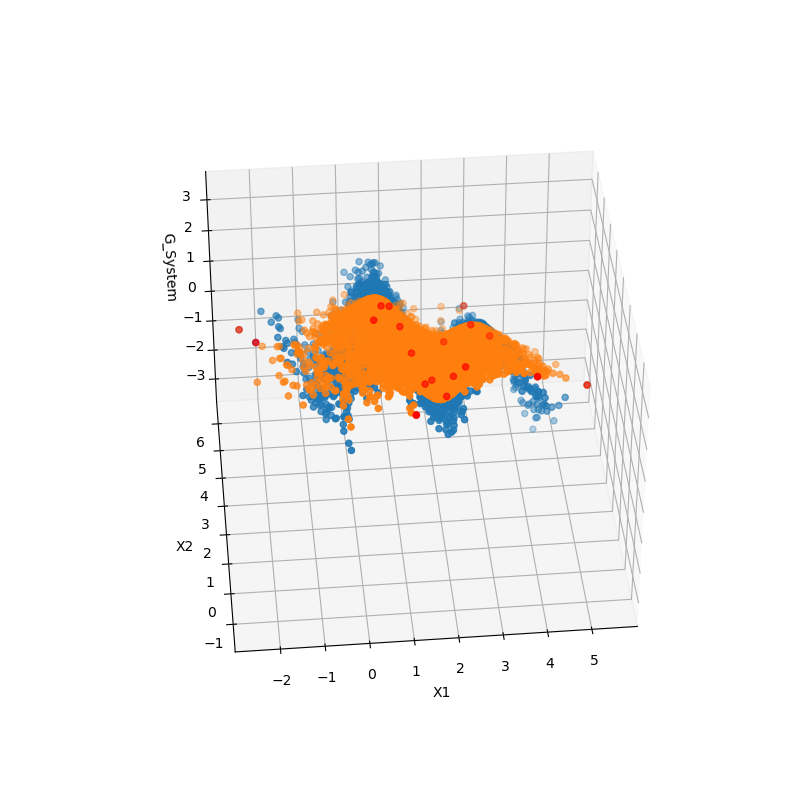

Text(0.5, 0, 'G_System')

In [467]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN)
ax.scatter(XR[:,0],XR[:,1], mean1)
# ax.scatter(XR[:,0],XR[:,1], mean0)
ax.scatter(xr[:,0],xr[:,1], yn, color='red')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('G_System')

# Failure probability estimation via MCS

In [444]:
MCS_samples = 100000

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))


MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

#model eval --------------------------------------------
gsyst = function(MCinputs)   
ymc = gsyst[0]
fail_samples = np.sum(ymc < 0 )
fail_prob = fail_samples/MCS_samples

In [445]:
#surrogate pred -----------------------------------------
mean_MCS = []
# var_MCS = []


for i in range (0, int(MCS_samples)):
    mean_,var_ = PCK1.predict(MCinputs_norm[i].reshape(1,-1))
    mean_MCS.append(mean_.tolist())
#     var_MCS.append(var_.tolist())

fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
fail_prob_SUMO = fail_samples_SUMO / MCS_samples

#Solution (Pf= 3.13E-2)

In [446]:
fail_prob, fail_prob_SUMO

(0.03119, 0.05237)

In [447]:
norm.ppf(fail_prob_SUMO)

-1.6222959287772578

In [402]:
fail_prob, fail_prob_SUMO

(0.0313, 0.0399)

In [399]:
fail_prob, fail_prob_SUMO

(0.0327, 0.0394)

In [ ]:
#selecting length scale ------------
dist = PCK1.distance(xn, xn)
#    llmin = np.min(dist[dist!=0])     #assigning the minimum distance between two points
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin

# 2D Plot

In [93]:
%%time
#predictions over a grid (for plotting)--------------------------------------------------

X1t,X2t = np.meshgrid(np.sort(XN[:,0]), np.sort(XN[:,1])) #grid over normalized points
Xt=np.stack((X1t,X2t),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

X1m,X2m = np.meshgrid(np.sort(XR[:,0]), np.sort(XR[:,1])) #grid over non-normalized points
Xtm=np.stack((X1m,X2m),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

yt=function(Xtm)    #test points
Mtest=yt[0]

response_plot=PCK1.predict(Xt)   #model predictions over (ntest x ntest) points
mean_plot=response_plot[0]
var_plot=response_plot[1]

Wall time: 3.81 s


LeaveOneOut_CrossValidation

In [25]:
#Generating PCK models for each reduced design of experiments 
PCK_loo = PC_Kriging(config)    # same 'config' as specified in the original model

mean_loo = np.zeros(n)
var_loo = np.zeros(n)

for i in range (0,n):             
    yn_loo=  np.delete(yn,[i])                              #y_n-i      leaving element i out the observations 
    xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the inputs (xr)
    xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the nomalized inputs (xn)

    #training LOO
    modelpar_loo = PCK_loo.train (xn_loo,yn_loo,p,theta)   # same (p, theta) as specified in the original model
     
    #predicting LOO
    mean_loo[i], var_loo[i] = PCK_loo.predict(xn[i].reshape(1,-1))
               
e_loo = (yn - mean_loo)**2              #LOO CV squared errors
sumat = np.divide(e_loo,var_loo)        #vector (e_loo / s_loo) for each observed point

LOOCV=np.zeros(ntest)

for k in range (0,ntest):               #variance enhancement based LOO CV erros around voronoi cells
    voro = VoronoiCell(XR[k],xr)
    
    LOOCV[k]= var_plot[k]*(1+sumat[voro])   

In [26]:
z=0    #target value
#-------------------------------------- EFF
eff1 = np.zeros(ntest)
eff1 = EFF(np.squeeze(mean1),LOOCV,z)
maxEff = np.argmax(eff1)
X_eff = XR[maxEff]
#-------------------------------------- U_function
U_f = U_function(mean1.reshape(-1), LOOCV.reshape(-1))
minU = np.argmin(U_f)
X_U = XR[minU]

<IPython.core.display.Javascript object>


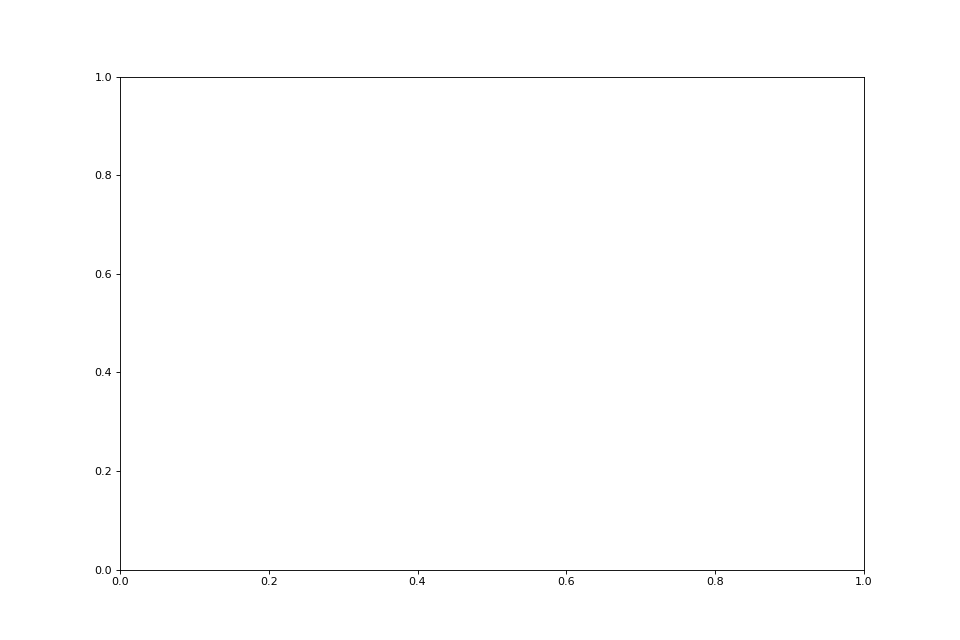

TypeError: Length of x (5000) must match number of columns in z (2)

In [449]:
fig =plt.subplots(figsize=(12, 8), dpi=80)

levels = 7
cs = plt.contourf(np.sort(XR[:,0]), np.sort(XR[:,1]), Mtest.reshape(ntest,-1), levels)
cbar=plt.colorbar(cs)

csm = plt.contour(np.sort(XR[:,0]), np.sort(XR[:,1]), mean_plot.reshape(ntest,-1) ,levels, colors='k')
plt.clabel(csm, fontsize=9, inline=1)

plt.scatter(xr[:,0],xr[:,1],color='red')

#-------------------------------------------------------------------------
# # # to check Voronoi cells influence vs observed points
# point = 0    #point index from MCinputs(any test array) 

# argum = VoronoiCell(XR[point],xr)

# print(XR[point], xr[argum], argum)

# plt.scatter(xr[argum,0],xr[argum,1],color='blue',marker = "x", s = 200)  #observations
# plt.scatter(XR[point,0],XR[point,1],color='blue',marker = "*", s = 200)  #test point
#-------------------------------------------------------------------------
# plotting of new points

plt.scatter(X_eff[0], X_eff[1] , color='blue', marker = "x", s = 200)  
# plt.scatter(X_U[0], X_U[1] , color='blue', marker = "*", s = 200)  
#-----------------------------------------------------------------------------------
cs.changed()